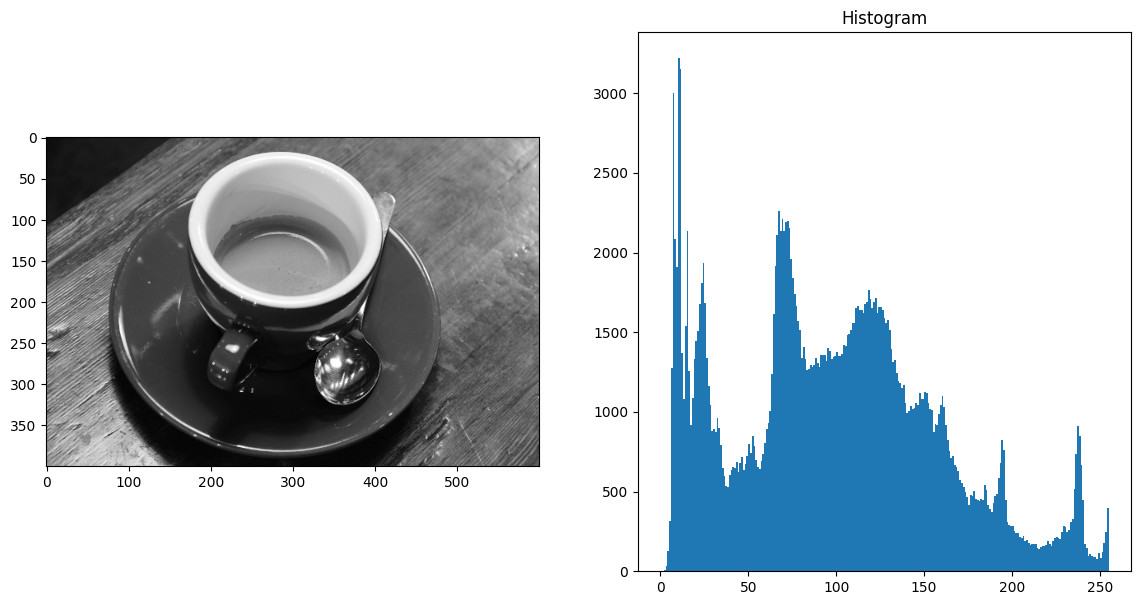

In [16]:
from skimage import data, img_as_ubyte
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

image = data.coffee()

img = rgb2gray(image)

img = img_as_ubyte(img)

# v_img = img.reshape(img.shape[0]*img.shape[1],1)

#histogram
fig = plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(img,cmap='gray')

plt.subplot(1,2,2)
plt.hist(img.ravel(),bins=255,density=False)
plt.title('Histogram')

plt.show()

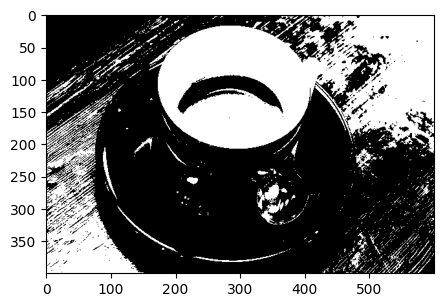

In [20]:
#manual threshold

t = 120

binary = img > 120

fig=plt.figure(figsize=(5,5))
plt.imshow(binary,cmap='gray')
plt.show()

# Simple and intuitive, but not adaptive. The result heavily depends on human observation and may not generalize.

101


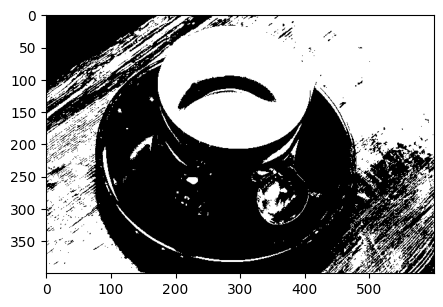

In [21]:
#otsu optimal threshold
from skimage.filters import threshold_otsu

t = threshold_otsu(img)
binary = img > t

print(t)
fig = plt.figure(figsize=(5,5))
plt.imshow(binary,cmap='gray')
plt.show()

# More accurate and adaptive than manual thresholding. Works well for bimodal histograms.

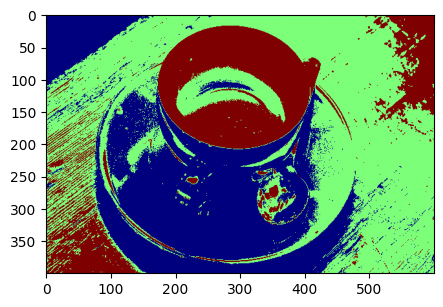

In [22]:
#otsu multiple thresholds
from skimage.filters import threshold_multiotsu
import numpy as np

t = threshold_multiotsu(img)
regions = np.digitize(img,bins=t)

fig = plt.figure(figsize=(5,5))
plt.imshow(regions,cmap='jet')
plt.show()

# Provides more fine-grained segmentation, especially useful when the image contains complex lighting or multiple objects.

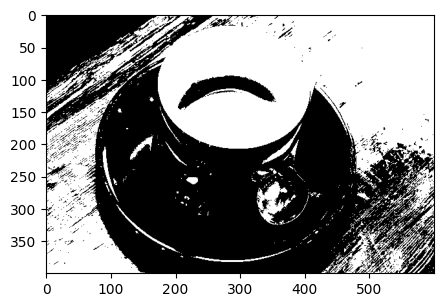

In [27]:
#KMeans
from sklearn.cluster import KMeans

v_img = img.reshape(img.shape[0]*img.shape[1],1)
kmeans = KMeans(n_clusters=2,random_state=0).fit(v_img)
regions = kmeans.predict(v_img)

kmeans_img = regions.reshape(img.shape[0],img.shape[1])

fig = plt.figure(figsize=(5,5))
plt.imshow(kmeans_img,cmap='gray')
plt.show()

# KMeans segments the grayscale image into 2 clusters based on intensity values.
# The segmentation is relatively sharp but can create abrupt transitions.
# Since KMeans assumes spherical clusters with equal variance, the results are sometimes less accurate in complex images.

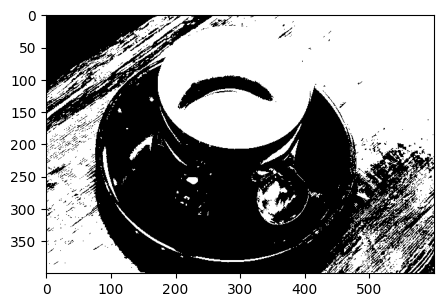

In [35]:
#Gaussian Mixture Models
from sklearn import mixture

gmm = mixture.GaussianMixture(n_components=2).fit(v_img)
regions = gmm.fit_predict(v_img)
regions = np.logical_not(regions)

gmm_img = regions.reshape(img.shape[0],img.shape[1])

fig = plt.figure(figsize=(5,5))
plt.imshow(gmm_img,cmap='gray')
plt.show()

# GMM provides a softer and more probabilistic segmentation.
# It models the pixel intensities using a mixture of Gaussians and allows for different variances per cluster.
# This gives a slightly more refined segmentation, especially in regions with overlapping intensities.

In [30]:
#GMM + BIC
nmax = 10
bic = []

for c in np.arange(1,nmax+1):
  gmm = mixture.GaussianMixture(n_components=c,covariance_type='full').fit(v_img)
  bic.append(gmm.bic(v_img))
  print(bic)

idx_winner = np.argmin(bic)
print('Winner : {}'.format(idx_winner))

gmm = mixture.GaussianMixture(n_components=idx_winner+1,covariance_type='full').fit(v_img)

[np.float64(2637511.869289643)]
[np.float64(2637511.869289643), np.float64(2629415.1142273825)]
[np.float64(2637511.869289643), np.float64(2629415.1142273825), np.float64(2617292.984629368)]
[np.float64(2637511.869289643), np.float64(2629415.1142273825), np.float64(2617292.984629368), np.float64(2582150.698771968)]
[np.float64(2637511.869289643), np.float64(2629415.1142273825), np.float64(2617292.984629368), np.float64(2582150.698771968), np.float64(2580612.0076183192)]
[np.float64(2637511.869289643), np.float64(2629415.1142273825), np.float64(2617292.984629368), np.float64(2582150.698771968), np.float64(2580612.0076183192), np.float64(2576407.2883827407)]
[np.float64(2637511.869289643), np.float64(2629415.1142273825), np.float64(2617292.984629368), np.float64(2582150.698771968), np.float64(2580612.0076183192), np.float64(2576407.2883827407), np.float64(2575337.5569119896)]
[np.float64(2637511.869289643), np.float64(2629415.1142273825), np.float64(2617292.984629368), np.float64(2582150

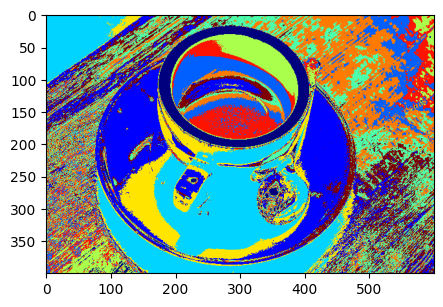

In [34]:
regions = gmm.fit_predict(v_img)

gmm_bic_img = regions.reshape(img.shape[0],img.shape[1])

fig = plt.figure(figsize=(5,5))
plt.imshow(gmm_bic_img,cmap='jet')
plt.show()

# Using the Bayesian Information Criterion (BIC), the algorithm chooses the optimal number of Gaussian components.
# In this case, it automatically selects the best k based on how well the model fits the data without overfitting.
# This version typically produces the most balanced segmentation among the three approaches.

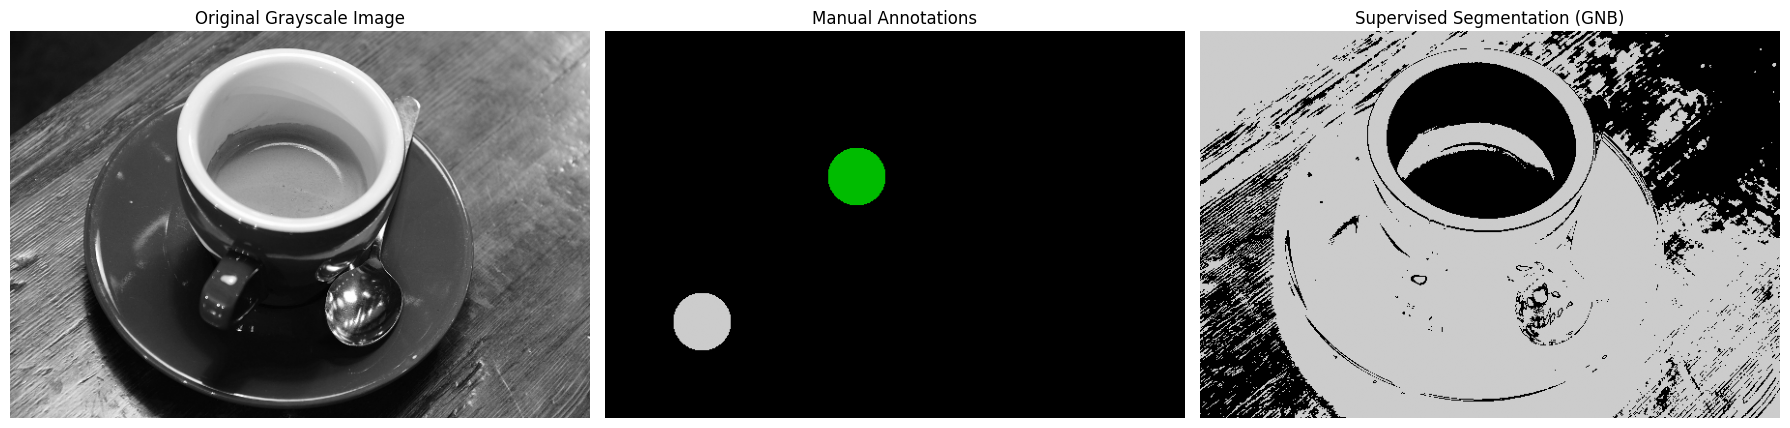

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from sklearn.naive_bayes import GaussianNB
from skimage.draw import disk

# Load image and convert to grayscale
image = data.coffee()
gray = color.rgb2gray(image)
img = img_as_ubyte(gray)

# Feature vector (grayscale intensity)
v_img = img.reshape(img.shape[0]*img.shape[1],1)

# Create synthetic labels manually (supervised!)
labels = np.zeros(img.shape, dtype=np.uint8)   # matrix ,with size as original image, filled with 0s which will help us to save segmentation levels

# Define foreground: coffee inside the cup (approximate)
rr_fg, cc_fg = disk((150, 260), 30)   # (row, col), radius
labels[rr_fg, cc_fg] = 1                       #define value 1 in all pixels of this area

# Define background: surrounding area
rr_bg, cc_bg = disk((300, 100), 30)
labels[rr_bg, cc_bg] = 2

# Prepare training data (only annotated pixels)
train_idx = np.where(labels.ravel() > 0)[0]
train_X = v_img[train_idx]
train_y = labels.ravel()[train_idx]

# Train Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(train_X, train_y)

# Predict full image
pred = gnb.predict(v_img)
seg_img = pred.reshape(img.shape)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(img, cmap='gray')
axs[0].set_title("Original Grayscale Image")
axs[0].axis('off')

axs[1].imshow(labels, cmap='nipy_spectral')
axs[1].set_title("Manual Annotations")
axs[1].axis('off')

axs[2].imshow(seg_img, cmap='nipy_spectral')
axs[2].set_title("Supervised Segmentation (GNB)")
axs[2].axis('off')

plt.tight_layout()
plt.show()

# In this task, we use a simple supervised learning approach for segmentation.
# A few manually annotated regions (foreground and background) serve as training data.
# Then, the Gaussian Naive Bayes (GNB) classifier is trained on grayscale intensity values and used to classify the rest of the image.

# Effectiveness:

# The method works reasonably well when the classes (regions) have different intensity distributions.
# It is easy to implement and quick to train, even on large images.
# GNB assumes feature independence and Gaussian distributions, which are often reasonable assumptions for grayscale pixel intensities.

# Limitations:

# The method is very sensitive to the quality and quantity of labeled data. Poor annotations = poor segmentation.
# It only uses pixel intensity as a feature — no spatial context is considered, which can lead to noise or incorrect borders.
# More advanced models (e.g., Random Forest, CNNs) could improve performance by using texture, color, and spatial relationships.

**Supervised Segmentation**

Definition:

Supervised segmentation methods use labeled training data, where each pixel (or region) has an associated class label (e.g., object vs background). The algorithm learns from these labeled examples to classify unseen pixels.

How it works:

You first provide the model with example pixels labeled as belonging to different classes (e.g., foreground, background). Then, the model trains a classifier (e.g., Naive Bayes, Linear Discriminant Analysis, neural networks) to predict labels on new images.

Example:

In medical imaging, you might manually label tumor regions in a few images to train a model that can segment tumors automatically in new scans.

**Unsupervised Segmentation**

Definition:

Unsupervised segmentation does not require labeled data. Instead, it tries to group pixels into clusters based on their similarity in features like color, texture, or intensity.

How it works:

Algorithms such as KMeans clustering or Gaussian Mixture Models (GMM) analyze pixel data and try to find natural groupings or clusters, assuming pixels in the same cluster belong to the same segment.

Example:

Segmenting a natural scene image into sky, vegetation, and water regions by grouping pixels with similar colors and textures without any prior labeling.

**Main Differences:**
Supervised segmentation relies on labeled data, meaning each pixel or region in the training images has a known class label (like foreground or background). The segmentation model learns from these labels to classify new, unseen images. In contrast, unsupervised segmentation does not require any labeled data; instead, it groups pixels based on their intrinsic features such as color or texture. The algorithm tries to find natural clusters in the data without prior knowledge of what those clusters represent. Because supervised methods use explicit training information, they tend to be more accurate and task-specific, while unsupervised methods are more exploratory and can be applied when labeled data is unavailable.

**Pros and Cons:**
Supervised segmentation generally produces better and more reliable results because it learns directly from the known classes, but its major drawback is the need for manually labeled training data, which can be expensive and time-consuming to obtain. Moreover, supervised models may overfit if the training data is limited or not representative of all possible cases. On the other hand, unsupervised segmentation does not require any labeling effort and can be quickly applied to any new dataset. However, the quality of the segmentation depends heavily on the chosen features and clustering algorithm. Unsupervised methods might group pixels in ways that do not correspond to meaningful or useful segments, sometimes mixing different objects or missing important details.